<a href="https://colab.research.google.com/github/decci027/datascience_a2/blob/main/Unit4ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

In [ ]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

In [ ]:
#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [ ]:
#identifies all the different amino acids in our data set
#and stores that information, plus original info, in the variable aa_encode
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode

['ILE', 'TYR', 'SER', 'ALA', 'ARG', ..., 'LYS', 'ARG', 'LYS', 'GLU', 'SER']
Length: 1776
Categories (19, object): ['ALA', 'ARG', 'ASN', 'ASP', ..., 'THR', 'TRP', 'TYR', 'VAL']

In [ ]:
#Replaces all the amino acid names with a number in the variable aa_idx
aa_idx = aa_encode.codes
aa_idx

array([ 8, 17, 14, ..., 10,  5, 14], dtype=int8)

In [ ]:
#stores the category names in a dictionary
#this dictionary format is required
#for pymc to properly read the categories
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}



---



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

# Normal distribution

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

Output()

Output()

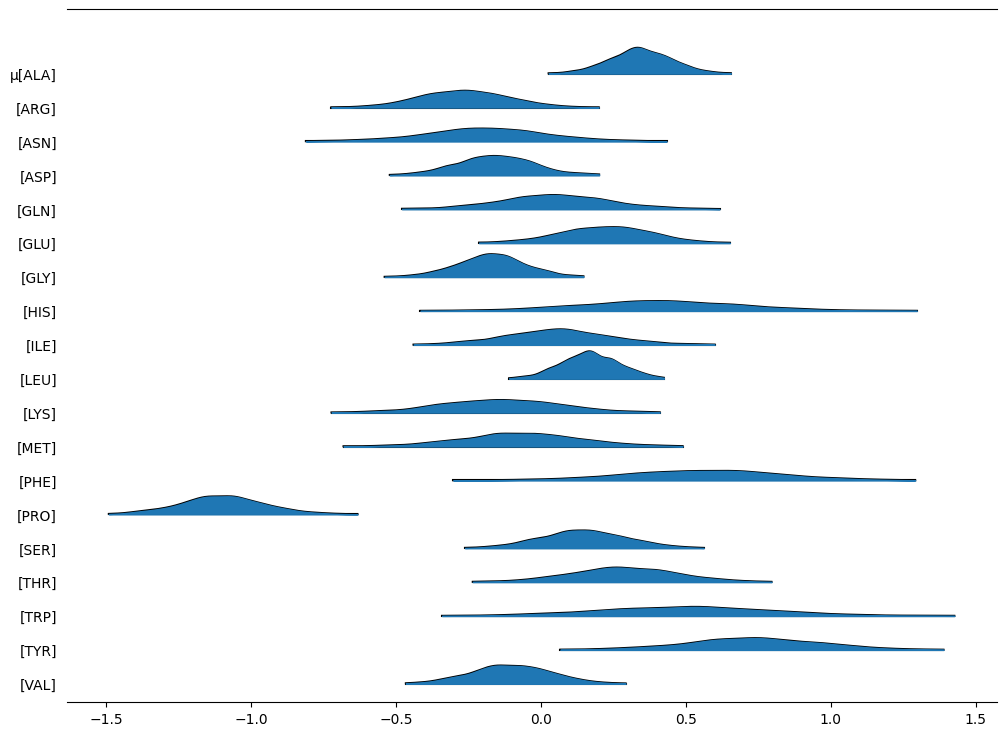

In [ ]:
#plots the middle 99.7% of each amino acids' posterior distribution of the mean
#why 99.7%? No reason, just seems like a good number to me.
#Feel free to pick your own hdi %; the default is 94%.
axes = az.plot_forest(idata_cs_h, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)


# Student T

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_studentt_model:
    # Hyperpriors
    μ_mu = pm.StudentT('μ_mu', nu=3, mu=0, sigma=10)
    μ_sd = pm.HalfStudentT('μ_sd', nu=3, sigma=10)

    # Priors
    μ = pm.StudentT('μ', nu=3, mu=μ_mu, sigma=μ_sd, dims="aa")
    σ = pm.HalfStudentT('σ', nu=3, sigma=10, dims="aa")

    # Likelihood
    y = pm.StudentT('y', nu=3, mu=μ[aa_idx], sigma=σ[aa_idx], observed=cs_data.diff_TminusE)

    # Sample
    idata_cs_h_studentt = pm.sample()

Output()

Output()

array([<Axes: >], dtype=object)

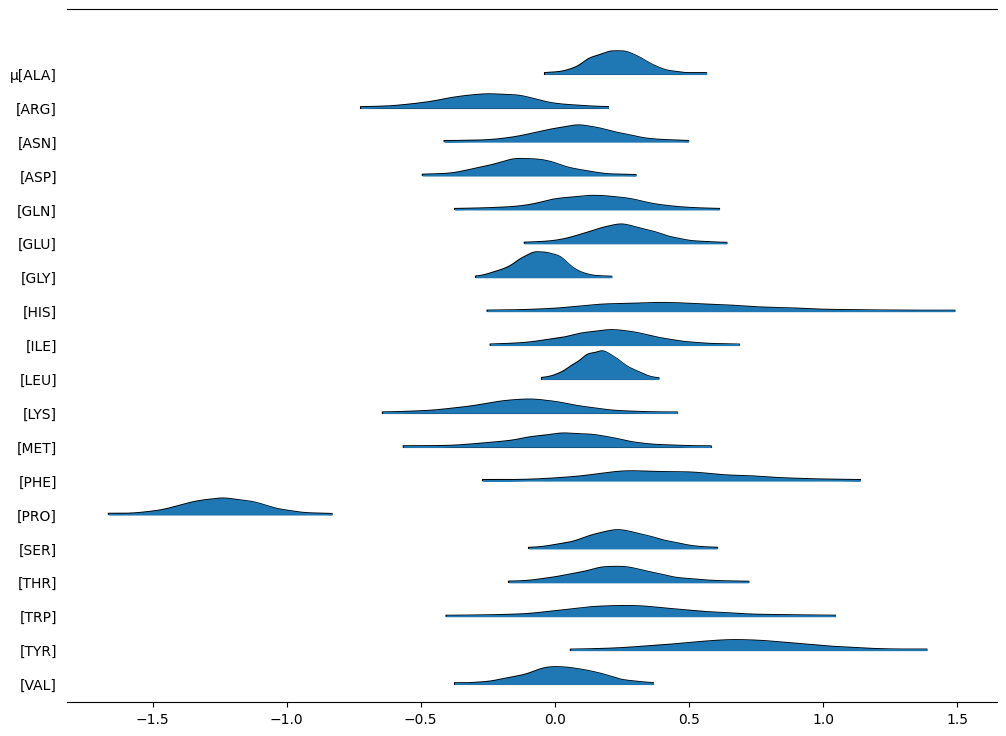

In [ ]:
az.plot_forest(idata_cs_h_studentt, kind="ridgeplot", var_names='μ', combined=True, figsize=(12, 9), hdi_prob=0.997)

### My Answer:
Student T seems to be favoring the right side a lot more meaning that majority of the data is right skewed. Student T also allows for more reprsenation of these skewed values compared to normal that diminishes the importance of those values.



---



**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

# Normal

In [ ]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

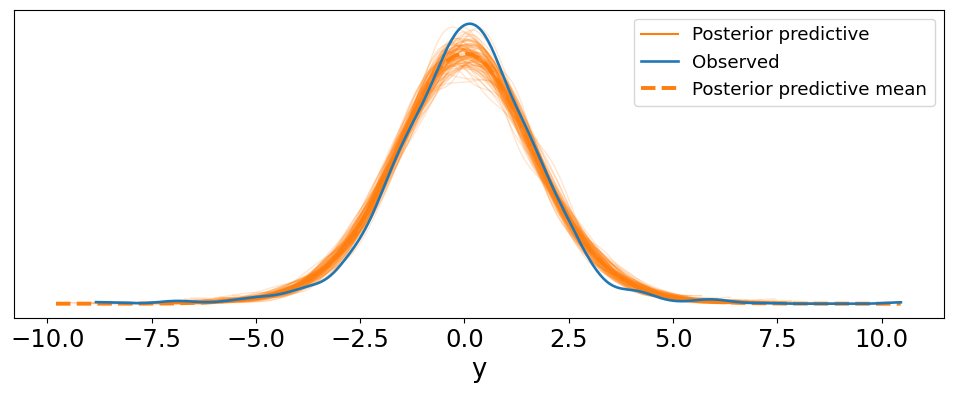

In [ ]:
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

# Student T

In [ ]:
pm.sample_posterior_predictive(idata_cs_h_studentt, model = cs_h_studentt_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

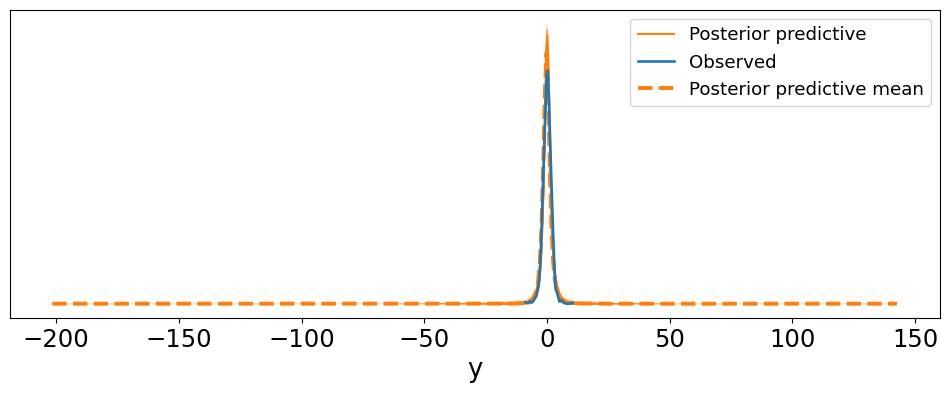

In [ ]:
az.plot_ppc(idata_cs_h_studentt, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

### My answer:
I think StudentT is a but better because the data seems to be more aligned in the PPC graph compared to the normal but that might be due to the scale. Overall I think both of them have really similar alignments.



---



**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [ ]:
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [ ]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_nh_model:
    # Parameters for positions
    μ_p = pm.Beta('μ_p', alpha = 2, beta = 20, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_nh = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details




---



**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

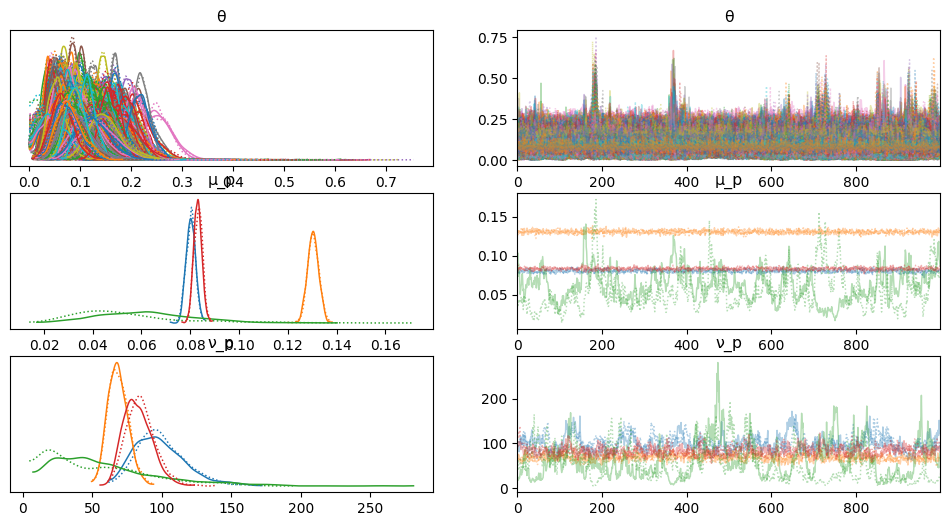

In [ ]:
az.plot_trace(idata_sccr_nh)

In [ ]:
az.rhat(idata_sccr_nh)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.003 1.003 0.9991 ... 0.9999 0.9999 1.0
    μ_p      (pos) float64 32B 1.0 1.003 1.055 1.003
    ν_p      (pos) float64 32B 1.007 1.01 1.093 1.012

When I compared my non-hierarchical model's plot-trace graph for theta with the hierarchical model in the notes, I noticed mine was a lot more erratic and had way more peaks. I think this is because the non-hierarchical model shows each group independently, while the hierarchical model compiles all the data together. For rhat, my μ_p was closer to 1 than the one in the notes, meaning mine had better convergence. But for v_p, the notes' numbers were closer to 1, so for that dataset, my model didn't converge as well. It was similar for theta—where the notes' values were slightly less than 1, mine were a bit higher.



---



**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

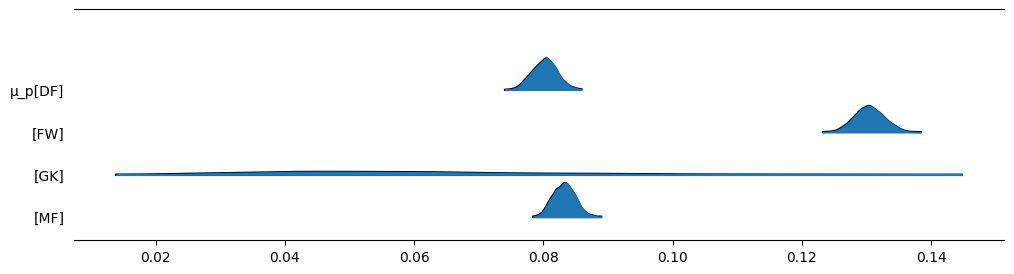

In [ ]:
az.plot_forest(idata_sccr_nh, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

### My answer:
Comparing my model with the one in the notes I found my range to be much smaller.



---



**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [ ]:
filtered_sccr_data = sccr_data[sccr_data['position'] != 'GK']

In [ ]:
pos_idx = filtered_sccr_data.position.cat.codes.values
pos_codes = filtered_sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}

In [ ]:
with pm.Model(coords=sccr_coords) as sccr_h_no_gk_model:
       # Hyperpriors
       μ_μ = pm.Beta('μ_μ', alpha=2, beta=20)
       ν_μ = pm.Gamma('ν_μ', mu=55, sigma=45)

       # Priors
       μ_p = pm.Beta('μ_p', alpha=μ_μ, beta=(1 - μ_μ) * ν_μ, dims="pos")
       ν_p = pm.Gamma('ν_p', mu=ν_μ, sigma=45, dims="pos")

       # Parameter for players
       θ = pm.Beta('θ', mu=μ_p[pos_idx], nu=ν_p[pos_idx])

       # Likelihood
       _ = pm.Binomial('gs',
                       n=filtered_sccr_data.shots.values,
                       p=θ,
                       observed=filtered_sccr_data.goals.values)

       # Sample
       idata_sccr_h_no_gk = pm.sample(target_accept=0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details




---



**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'μ_μ'}>, <Axes: title={'center': 'μ_μ'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>],
       [<Axes: title={'center': 'ν_μ'}>, <Axes: title={'center': 'ν_μ'}>]],
      dtype=object)

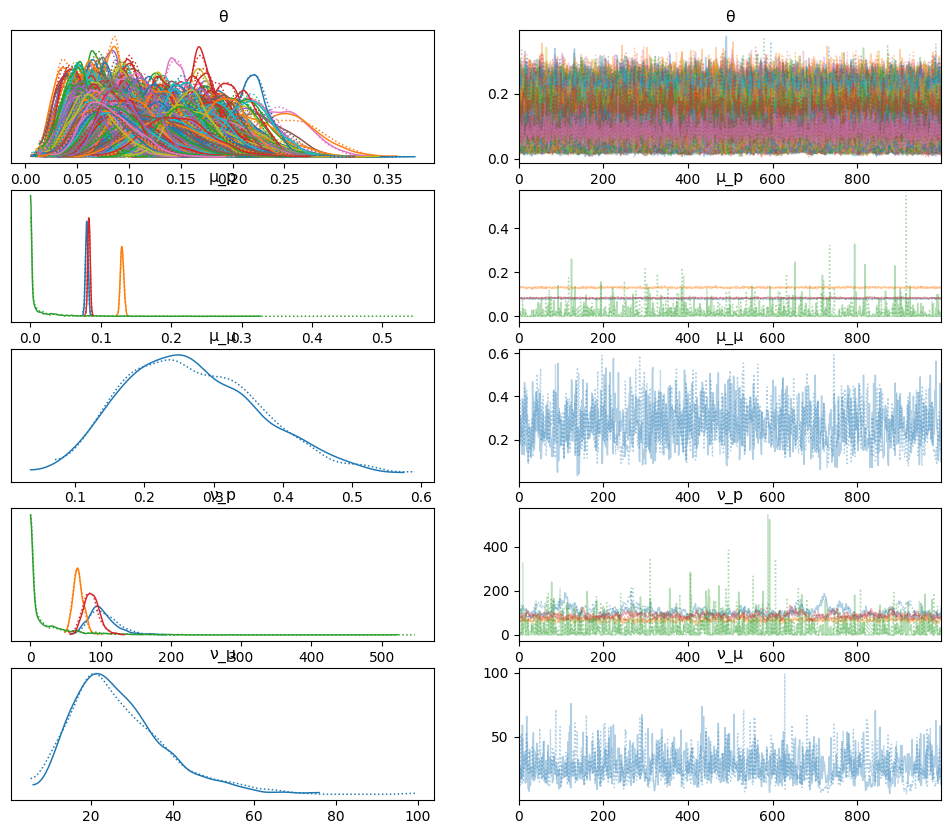

In [ ]:
az.plot_trace(idata_sccr_h_no_gk)

In [ ]:
az.rhat(idata_sccr_h_no_gk)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.004 1.001 1.0 1.002 ... 1.001 1.001 1.005
    μ_p      (pos) float64 32B 1.002 1.001 1.002 1.001
    μ_μ      float64 8B 1.001
    ν_p      (pos) float64 32B 1.025 1.002 1.006 1.019
    ν_μ      float64 8B 1.004

##Conclusion:
I think the model without the goalkeeper is easier for pymc to handle since there’s less data for it to process. By dropping the GKs, we got a much more normal-looking graph without that huge peak around 200. That said, we lost a key part of the dataset, which obviously influenced the graphing and analysis because that big peak at 200 is gone. If we’re just focusing on defenders, midfielders, and forwards, this could be helpful. But if we’re looking at soccer as a whole, leaving out the GKs doesn’t really give an accurate representation of the data. If we only care about the field players, though, dropping the GKs is valuable since the data isn’t so dominated by that peak at 200. It really depends on what you’re trying to do with the data and what you’re looking for.